In [629]:
%matplotlib notebook
import mne
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from sklearn import linear_model
# athenacli -e prod -w3 -n0 -p KET -o . EEGTEST

### Load the montage of sensor channel locations and set up the files to process.

In [630]:
montage = mne.channels.read_montage('standard_1020')
#edf_file = 'EEG_TEST_0001_raw.edf'
#log_file = 'log3.csv'
edf_file = os.path.expanduser('~/data/eeg/20190701/aditya_TEST_raw.edf')
log_file = os.path.expanduser('~/data/eeg/20190701/adityaTest.csv')

In [631]:
raw = mne.io.read_raw_edf(edf_file, stim_channel='Trigger', eog=['EEG X1-Pz'], 
                          misc=['EEG CM-Pz','EEG X2-Pz','EEG X3-Pz'])
# Rename the channels so they match the standard montage channel names
raw.rename_channels({c:c.replace('EEG ','').replace('-Pz','') for c in raw.ch_names})
raw.set_montage(montage)
eeg_sample_interval_ms = 1/raw.info['sfreq'] * 1000
print(raw.info)
#raw.plot_sensors()

Extracting EDF parameters from /Users/bdougherty/data/eeg/20190701/aditya_TEST_raw.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
<Info | 17 non-empty fields
    bads : list | 0 items
    ch_names : list | P3, C3, F3, Fz, F4, C4, P4, Cz, CM, ...
    chs : list | 25 items (EEG: 20, MISC: 3, EOG: 1, STIM: 1)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    dig : list | 23 items (3 Cardinal, 20 EEG)
    events : list | 0 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 150.0 Hz
    meas_date : tuple | 2019-07-01 14:49:14 GMT
    nchan : int | 25
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 300.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_a

### Find the events

In [632]:
events = mne.find_events(raw)

818 events found
Event IDs: [  1   3   4   5   6   8   9  10  11  12  13  14  15  16  17  18  19  20
  21  22  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39
  40  41  42  43  45  46  47  48  50  51  52  53  54  55  56  57  58  60
  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78
  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97
  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115
 116 118 119 120 121 123 125 126 127 128 129 130 132 134 135 136 137 138
 139 140 141 142 143 145 146 147 149 150 151 152 153 154 155 156 157 159
 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177
 179 180 181 182 183 184 185 186 188 189 190 191 192 193 194 195 196 198
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 229 230 231 232 233 234 235 236
 237 238 239 240 241 242 243 244 245 246 247 248 250 251 252 253 255]


In [633]:
logdf = pd.read_csv(log_file, header=None, names=['client_ts','trigger_ts','rtdelay','msg','uid'])
logdf.client_ts = (logdf.client_ts * 1000).round().astype(int)
logdf.trigger_ts = (logdf.trigger_ts * 1000).round().astype(int)
logdf['bytecode'] = logdf.client_ts % 255 + 1
logdf = logdf.sort_values('client_ts').reset_index(drop=True)
#phone_start = 722
#logdf = logdf.iloc[722:, :]
logdf.head()

,client_ts,trigger_ts,rtdelay,msg,uid,bytecode
0,1562017468458,1562017473516,0,event,1,214
1,1562017478564,1562017483758,0,event,2,120
2,1562017492148,1562017497461,0,event,2,189
3,1562017516250,1562017520699,0,event,2,66
4,1562017543235,1562017548210,0,event,2,21


In [785]:
eventdf = pd.DataFrame(events, columns=['time_idx','prev_diff','bytecode'])
# NOTE: the eeg timestamp is local time, not UTC! Be sure to use the correct adjustment here.
event_start_ts = int(raw.info['meas_date'][0]) + 7*60*60
eventdf['eeg_ts'] = ((eventdf.time_idx / 300 + event_start_ts) * 1000).round().astype(int)
eventdf.head()

,time_idx,prev_diff,bytecode,eeg_ts
0,359,0,84,1562017755197
1,1118,0,165,1562017757727
2,1207,0,154,1562017758023
3,1360,0,177,1562017758533
4,1523,0,135,1562017759077


### Find the best-matching bytecode for each event

In [905]:
window = 30000 # +/-, in milliseconds
match_inds = []
for event_idx in eventdf.index:
    tmp = logdf.loc[np.abs(eventdf.eeg_ts[event_idx] - logdf.trigger_ts) < window, :]
    matches = tmp.index[tmp.bytecode == eventdf.bytecode[event_idx]]
    if len(matches) > 0:
        for match in matches:
            # See if the surrounding bytecodes match. If so, add this to the list
            keep = False
            try:
                keep = True
                for idx in range(-9,10):
                    if (tmp.bytecode[match + idx] != eventdf.bytecode[event_idx + idx]):
                        keep = False
                        continue
            except:
                #print(tmp.bytecode[match[0]+1], eventdf.bytecode[event_idx+1])
                pass
            if keep:
                match_inds.append((logdf.msg[match], match, event_idx, logdf.trigger_ts[match], logdf.client_ts[match],
                                    eventdf.eeg_ts[event_idx], eventdf.time_idx[event_idx], logdf.rtdelay[match]))
                
print('Found %d matching timepoints.' % len(match_inds))
cols = ['msg','logdf_idx','eventdf_idx','trigger_ts','client_ts','eeg_ts','eeg_samp','rt_delay']
matchdf = pd.DataFrame(data=match_inds, columns=cols)
matchdf = matchdf.sort_values('client_ts').reset_index(drop=True)
matchdf.loc[matchdf.rt_delay <= 0, 'rt_delay'] = np.nan
matchdf.loc[matchdf.msg.isin(msgs) & (matchdf.rt_delay>500),:]

Found 660 matching timepoints.


,msg,logdf_idx,eventdf_idx,trigger_ts,client_ts,eeg_ts,eeg_samp,rt_delay
147,imageFlip,150,139,1562017824330,1562017815359,1562017831300,23190,10735.0
148,imageFlip,151,140,1562017824399,1562017815859,1562017831367,23210,10735.0
149,imageFlip,151,191,1562017824399,1562017815859,1562017853300,29790,10735.0
150,imageFlip,152,141,1562017824437,1562017816359,1562017831407,23222,10735.0
151,imageFlip,152,192,1562017824437,1562017816359,1562017853373,29812,10735.0
152,imageFlip,153,193,1562017824506,1562017816859,1562017853487,29846,11490.0
153,imageFlip,153,142,1562017824506,1562017816859,1562017831473,23242,11490.0
154,imageFlip,154,194,1562017824554,1562017817359,1562017854120,30036,10488.0
155,imageFlip,154,143,1562017824554,1562017817359,1562017831523,23257,10488.0
156,imageFlip,155,144,1562017824623,1562017817859,1562017831590,23277,9701.0


### Find the optimal fuzzy alignment between the log file and event bytecode sequence
Piecewise-linear should be used to minimze the error accumulation across long recording runs.
http://www.xavierdupre.fr/app/mlinsights/helpsphinx/notebooks/piecewise_linear_regression.html

In [833]:
tmp = matchdf.copy(deep=True).loc[matchdf.msg.isin(msgs),:]
tmp.reset_index(inplace=True)
tmp['netdelay'] = tmp.rt_delay.shift(-1) / 2
tmp.netdelay.fillna(tmp.netdelay.mean(), inplace=True)
#tmp.head()
#plt.scatter(tmp.client_ts, tmp.trigger_ts, color='g')
#plt.scatter(tmp.client_ts, tmp.trigger_ts-tmp.netdelay, color='b')

In [916]:
def fit_timestamps(matchdf, msgs, mad_scale=100, correct_delay=True):
    tmp = matchdf.copy(deep=True).loc[matchdf.msg.isin(msgs),:]
    tmp.reset_index(inplace=True)
    tmp['netdelay'] = np.nan
    # the round-trip delay stored in row n is actually for row n-1 
    tmp['netdelay'] = tmp.rt_delay.shift(-1) / 2
    # mean-fill the net delay
    delay_mean = tmp.netdelay.median()
    delay_std = tmp.netdelay.std()
    tmp.netdelay.fillna(delay_mean, inplace=True)
    
    # The eeg timestamps are shifted back in time, as if there were no network delay. This 
    # leaves the clock bias as only difference (on average) between the eeg and client timestamps.
    x = tmp.client_ts.values
    if correct_delay:
        y = tmp.eeg_ts.values - delay_mean
        # FIXME-- should be tmp.netdelay, but we may have an issue with rt_times
    else:
        y = tmp.eeg_ts.values
    # WORK HERE: 
    # Offset includes clock bias (same for all measurements) and the timing error for this one measurment.
    # The intercept in the fitted model *should* take care of this, but may require more thought to be sure.
    offset = y[0]
    x = x - offset
    y = y - offset

    X = np.atleast_2d(x).T

    # Robust linear fit
    thresh = (np.abs(y - y.mean())).mean() / mad_scale
    client_to_eeg = linear_model.RANSACRegressor(residual_threshold=thresh)
    client_to_eeg.fit(X, y)
    
    x_keep = logdf.client_ts[logdf.msg.isin(msgs)].values - offset
    predicted_eeg_ts = (client_to_eeg.predict(np.atleast_2d(np.array(x_keep)).T) + offset - event_start_ts*1000) 
    predicted_eeg_samp = (predicted_eeg_ts / (1000/300)).round().astype(int)
    # Predict data of estimated models
    #y_hat = client_to_eeg.predict(np.atleast_2d(x).T) 
    #plt.plot(x, y, 'ro', x, y_hat, 'k-')
    #print('x0=%d, y0=%d, y_hat0=%d, offset=%d' % (x[0],y[0],int(round(y_hat[0])),offset))
    #print(client_to_eeg.estimator_.coef_[0], client_to_eeg.estimator_.intercept_)
    #outliers = np.argwhere(client_to_eeg.inlier_mask_ == False).flatten()
    #print(','.join([str(v) for v in outliers]))
    print('using %s (options are: %s)' % (','.join(msgs), ', '.join(pd.unique(matchdf.msg))))
    outmask = client_to_eeg.inlier_mask_ == False
    print('Rejecting %d out of %d sample pairs.' % (outmask.sum(), len(outmask)))
    print('Mean network delay: %0.2f ms (%0.2f stdev)' % (delay_mean, delay_std))
    return predicted_eeg_samp,client_to_eeg,offset


### Synthesize a corrected event sequence
This new sequence takes into account the random delay from one even to the next and the average network delay. Because event trigger packets can arrive out-of-order, they needed to be resorted above to apply the proper delays. But now that everything is corrected, we can resort them based on the event timestamp so mne doesn't complain about a non-chronological event sequence.

In [927]:
bias = int(round(100 / (1/.3)))
msgs = ['imageFlip']
predicted_eeg_samp,client_to_eeg,offset = fit_timestamps(matchdf, msgs, correct_delay=True)

syn_event_df = pd.DataFrame([(i+bias,0,1) for i in predicted_eeg_samp], columns=['ts','diff','code'])
raw_no_ref,_ = mne.set_eeg_reference(raw.load_data().filter(l_freq=None, h_freq=45), [])
#raw_no_ref, _ = mne.set_eeg_reference(raw.load_data(), [])
reject = dict(eeg=150e-6) # 180e-6, eog=150e-6)
event_id, tmin, tmax = {'visual': 1}, -0.05, 0.5
epochs_params = dict(events=syn_event_df.values, event_id=event_id, tmin=tmin, tmax=tmax, reject=reject)
evoked_no_ref = mne.Epochs(raw_no_ref, **epochs_params).average()

predicted_eeg_samp,client_to_eeg,offset = fit_timestamps(matchdf, msgs, correct_delay=False)
syn_event_df = pd.DataFrame([(i+bias,0,1) for i in predicted_eeg_samp], columns=['ts','diff','code'])
epochs_params = dict(events=syn_event_df.values, event_id=event_id, tmin=tmin, tmax=tmax, reject=reject)
evoked_no_ref_uncorrected = mne.Epochs(raw_no_ref, **epochs_params).average()

del raw_no_ref  # save memory

using imageFlip (options are: event, imageFlip, good click, early click, normal, oddball)
Rejecting 61 out of 364 sample pairs.
Mean network delay: 102.50 ms (955.19 stdev)
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 89 samples (0.297 sec)

EEG data marked as already having the desired reference. Preventing automatic future re-referencing to an average reference.
361 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2']
    Rejecting  epoch b

<IPython.core.display.Javascript object>


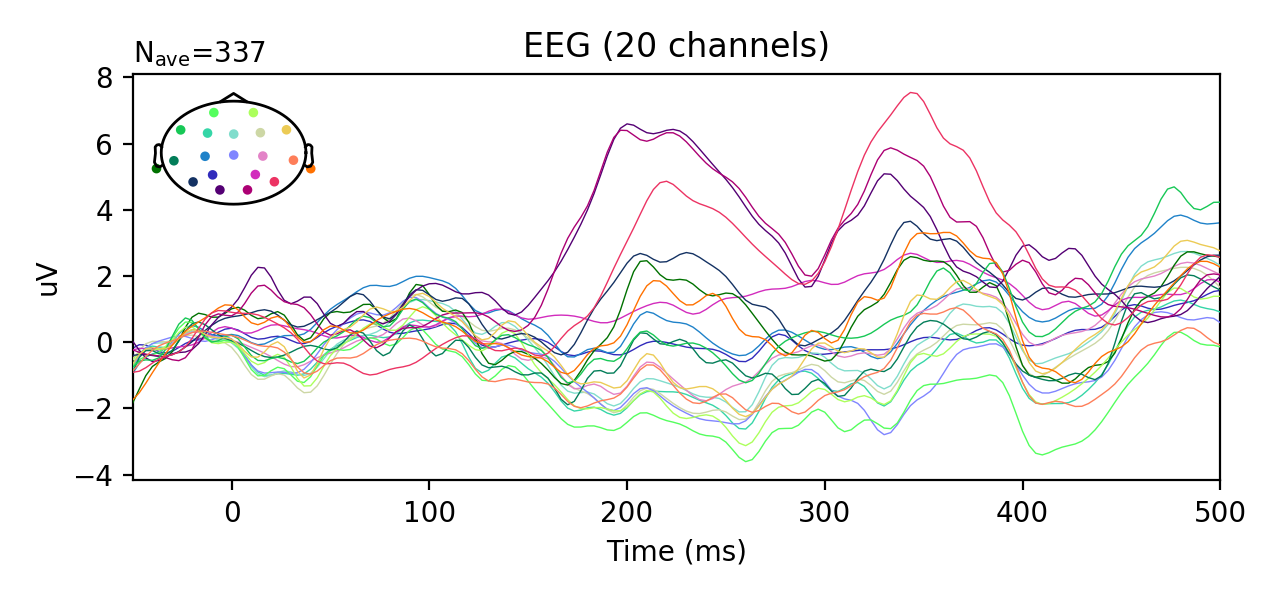

In [929]:
p = evoked_no_ref.plot(time_unit='ms', spatial_colors=True)
#p = evoked_no_ref_uncorrected.plot(time_unit='ms', spatial_colors=True)
#t = evoked_no_ref.plot_topomap(times=[0.075,0.1,0.125,.15,.175], size=1.0, title=title, time_unit='s')

<IPython.core.display.Javascript object>


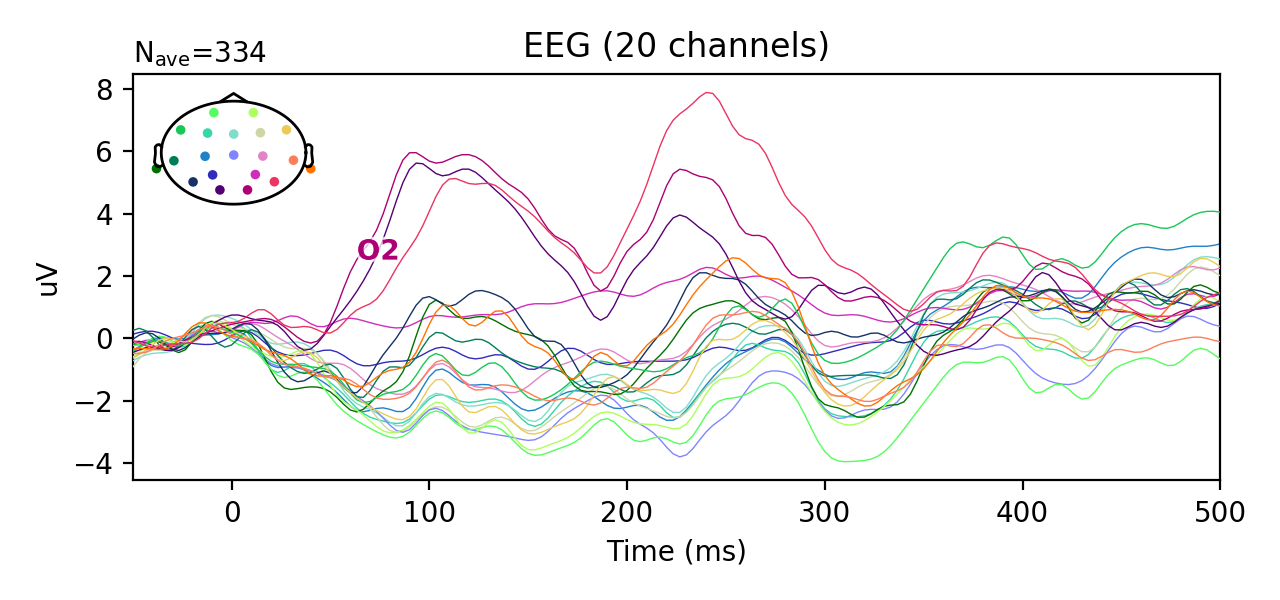

In [928]:
#p = evoked_no_ref.plot(time_unit='ms', spatial_colors=True)
p = evoked_no_ref_uncorrected.plot(time_unit='ms', spatial_colors=True)
#t = evoked_no_ref.plot_topomap(times=[0.075,0.1,0.125,.15,.175], size=1.0, title=title, time_unit='s')

### Sample code for doing frequency analysis

In [726]:
occ = raw.get_data(['O1','O2'])[:,predicted_eeg_idx[0]:predicted_eeg_idx[-1]]
occ.shape

(2, 53999)

In [727]:
ft = np.fft.rfft(occ)
T = eeg_sample_interval_ms / 1000
xf = np.linspace(0.0, 1.0/(2.0*T), int(np.ceil(occ.shape[1]/2))+1)

<IPython.core.display.Javascript object>


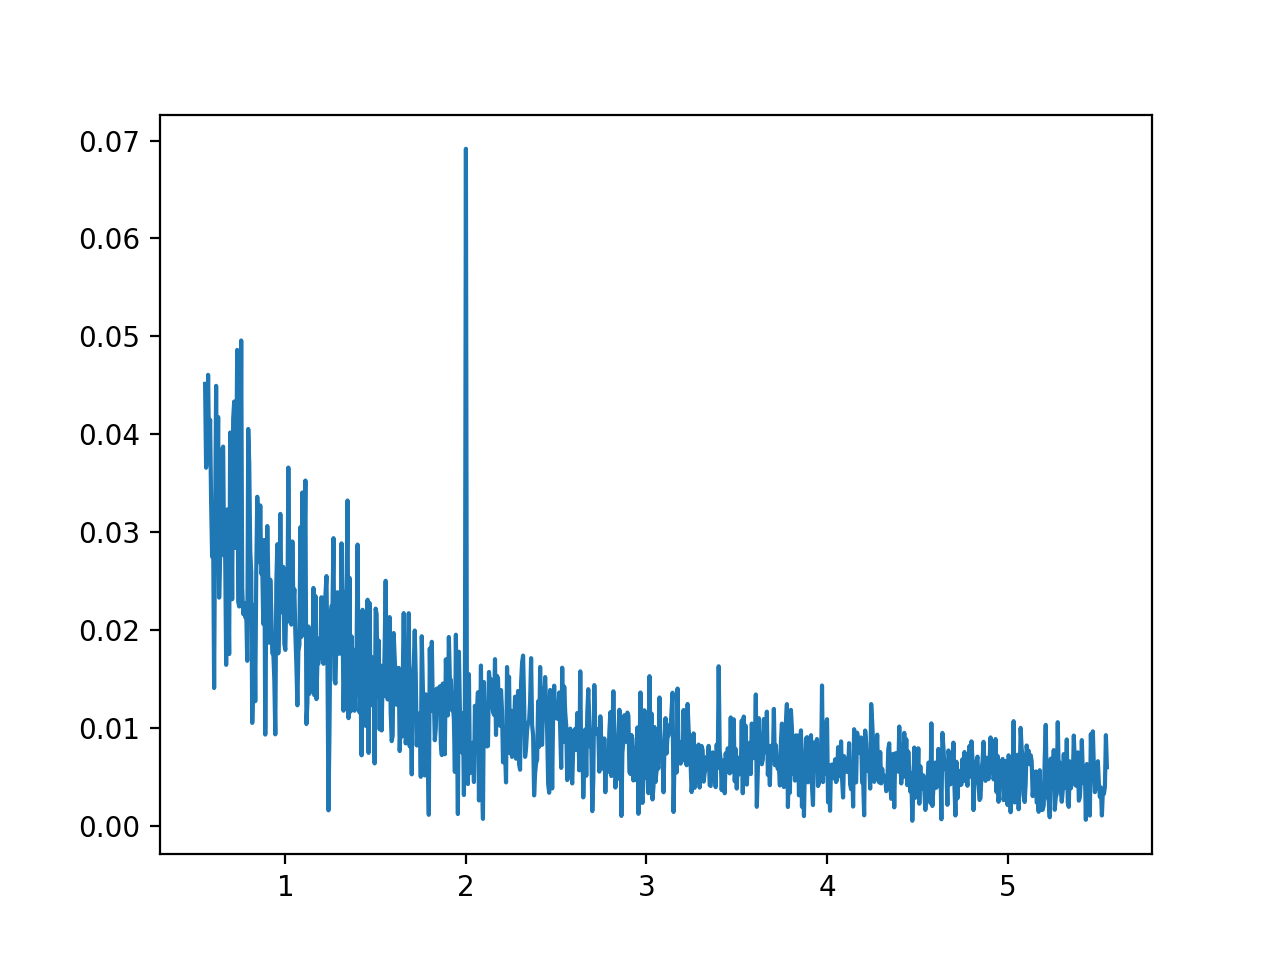

In [730]:
fig = plt.Figure(figsize=(12,6))
plt.plot(xf[100:1000], np.abs(ft[1,100:1000]))

In [ ]:
logdf.head()

In [ ]:
plt.plot(df.client_ts)

In [ ]:
df.head()

In [ ]:
raw.get_data().shape